<a href="https://colab.research.google.com/github/w3dip/sberbank_machine_learning/blob/master/homework2_reboot_Pavlov_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание 2
### Линейные модели
---


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#### Задание 1 (Теоретическое)
На лекции было сказано, что большие по модулю веса могут сигнализировать о наличии переобучения или о наличии линейной зависимости между признаками. В этом задании вам предстоит показать, что при отсутствии регуляризации (штрафа за большие веса) коэффициенты перед зависимыми признаками могут расти неограниченно.

Рассмотрим данные, в которых истинная зависимость целевой переменной $y$ от признака $x$ описывается коэффициентом w (то есть истинная зависимость выглядит как $y = wx + ...$, где ... - другие признаки НЕ ЗАВИСЯЩИЕ от x). Искусственно добавим в модель зависимый признак равный -x. 
После обучения модели получим зависимость $y = w_1x + w_2 (-x) + ...$.

Покажите, что веса $w_1$ и $w_2$ могут быть сколь угодно большими.

<Ваш ответ здесь>  
$y = (w_1 - w_2)x + ...$

$w_1 - w_2$ сходится к точному решению, но сами $w_1, w_2$ могут быть любыми числами.
Например, решение требует $w_1 - w_2 = 1$.
$w_1=1000, w_2=999$ - решение

#### Задание 2

Линейная регрессия с L2-регуляризацией или Ridge регрессия состоит в минимизации следующего функционала:
$$||Y - Xw||^2 + \lambda ||w||^2 \rightarrow min$$

Для данной задачи можно выписать явное решение:
$$w = (X^TX + \lambda I)^{-1}X^TY$$

Реализуйте свой класс для гребневой регрессии, воспользовавшись формулой выше.

In [0]:
class MyRidgeRegression:
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.w = None
    
    def fit(self, X, y):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        # Не забудьте про фиктивный признак равный 1!
        X = np.concatenate([X, np.ones([len(X), 1])], 1)
        # Не применяйте регуляризацию к параметру b
        
        # ВАШ КОД ЗДЕСЬ
        # Коэффициент лямбда сохранен в переменной self.alpha
        # Вам может понадобиться функция np.eye
        arg1 = X.T @ X
        #arg2 = self.alpha*np.eye(len(arg1))
        #self.w = np.linalg.solve(self.alpha*np.eye(len(res1)) + res1, X.T.dot(y))
        self.w = np.linalg.inv(arg1 + self.alpha * np.eye(len(arg1))) @ X.T @ y
        
        
    def predict(self, X):
        # Принимает на вход X и возвращает ответы модели
        X = np.concatenate([X, np.ones([len(X), 1])], 1)
        # ВАШ КОД ЗДЕСЬ
        y_pred = X @ self.w
        return y_pred
    
    def get_weights(self):
        return self.w

Протестируем наш алгоритм на искусственных данных и сравним с линейной регрессией без регуляризации

In [0]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=100)

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [0]:
linear_regr = LinearRegression()
ridge_regr = MyRidgeRegression(alpha=0.1)

linear_regr.fit(X_train, y_train)
ridge_regr.fit(X_train, y_train)

linear_regr_predictions = linear_regr.predict(X_test)
ridge_regr_predictions = ridge_regr.predict(X_test)

В качестве метрики качества воспользуемся MAE (средняя абсолютная ошибка)

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [91]:
print('Linear regression: ', mean_absolute_error(y_test, linear_regr_predictions))

Linear regression:  111.88381759824254


In [92]:
print('Ridge regression: ', mean_absolute_error(y_test, ridge_regr_predictions))

Ridge regression:  111.22396795453419


Попробуйте подобрать такой коэффициент регуляризации, чтобы ошибка на тесте была меньше, чем у модели без регуляризации.

In [94]:
from sklearn.linear_model import Ridge
alpha = 0
ridge = Ridge(alpha)
ridge.fit(X_train, y_train)
print('mae ridge: ', mean_absolute_error(y_test, ridge.predict(X_test)))

mae ridge:  112.5610342249991


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.80562e-18): result may not be accurate.
  overwrite_a=False)


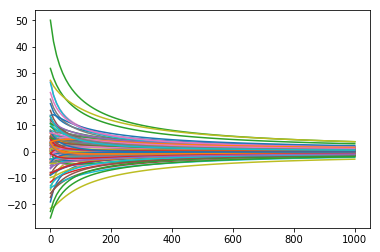

In [65]:
alphas = np.linspace(1, 1000, 100)

weights = np.empty((X.shape[1], 0))
for alpha in alphas:
    ridge_regressor = Ridge(alpha)
    ridge_regressor.fit(X_train, y_train)
    weights = np.hstack((weights, ridge_regressor.coef_.reshape(-1, 1)))
plt.plot(alphas, weights.T)
plt.show()

#### Задание 3
В этом задании предлагается поиграться с различными ядрами SVM и подобрать лучшие параметры для каждого из них

Вам дан датасет (находится в файле banknote.data), в котором представлены различные статистики подсчитанные для изображения купюр. Задача состоит в классификации купюр на подлинные и фальшивые на основе этих данных.
(Подробнее https://archive.ics.uci.edu/ml/datasets/banknote+authentication)

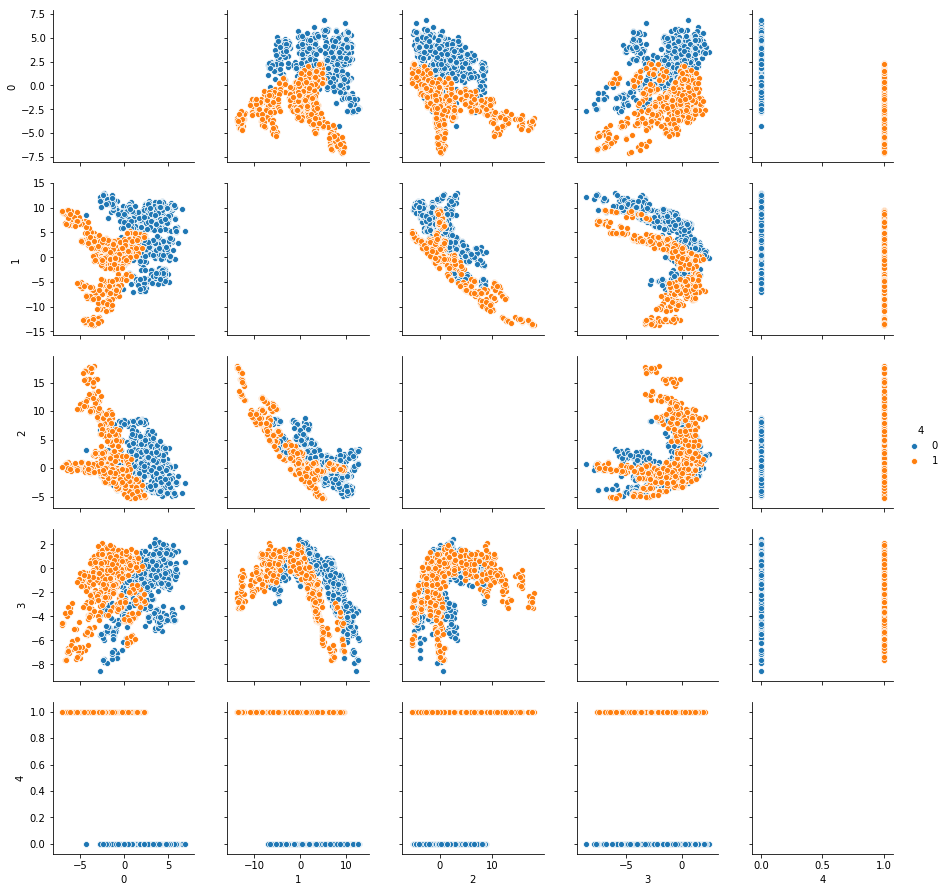

In [98]:
import seaborn as sns

data = pd.read_csv('banknote.data', sep=',', header=-1)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# одновременно нарисовать график и цветной и с распределениями не получается (особенность датасета)
sns.pairplot(data, diag_kind='', hue=4)
#sns.pairplot(data, diag_kind='')

Разделите выборку на трейн и тест в соотношении 1:1

In [0]:
# ВАШ КОД ЗДЕСЬ

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [0]:
from sklearn.svm import SVC

Для каждого из ядер svc (параметр kernel='linear', 'poly', 'rbf') постарайтесь подобрать наилучший набор параметров, который максимизирует метрику F1-score на тесте. 

НАПОМИНАНИЕ: $ F1 = 2\frac{precision \cdot recall}{precision + recall} $

ПОДСКАЗКА: параметр C в SVC отвечает за коэффициент регуляризации, degree - степень полинома в полиномиальном ядре, gamma - коэффициент в экспоненте у гауссовского ядра. Про другие парамеры (если понадобятся) предлагается прочитать самостоятельно.

In [0]:
from sklearn.metrics import f1_score, make_scorer

In [0]:
# ВАШ КОД ЗДЕСЬ

#### БОНУС

Предлагаю немного расслабиться и посмотреть как делается полиномиальная регрессия (добавление степенных признаков в модель) и как Lasso проводит отбор признаков.

In [0]:
# Data generation

def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-10, 10, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 100
w_true[3] = -1
beta_true = 1e-4

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
plt.figure(figsize=(10, 5))
plt.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
plt.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [0]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=20, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False)
ridge.fit(X_train, t_train)
w_ridge = ridge.coef_

In [0]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV, Lasso
lasso = LassoCV(cv=20, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False)
lasso.fit(X_train, t_train)
w_lasso = lasso.coef_

In [0]:
def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

# Comparison
print('Ridge Regression')
print('Features remaining:', np.sum(np.abs(w_ridge) > 1e-15), '/', d)
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-'*50)
print('Lasso Regression')
print('Features remaining:', np.sum(np.abs(w_lasso) > 1e-15), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

plt.figure(figsize=(10, 5))
plt.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
plt.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')
plt.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
plt.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()